<a href="https://colab.research.google.com/github/Hacxmr/log-analysis/blob/main/CIC_IDS_2017.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import files
uploaded = files.upload()  # Choose CIC-IDS 2017.zip


Saving CIC-IDS 2017.zip to CIC-IDS 2017.zip


In [12]:
import os
os.listdir('cic_ids_2017')


['Monday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv']

In [13]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('cic_ids_2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')  # Change filename accordingly

# Separate features and label
X = df.drop([' Label'], axis=1)
y = df[' Label']

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [15]:
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
# Replace inf and -inf with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values with the column mean
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)



In [21]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9999335533455891

Confusion Matrix:
 [[19404     1]
 [    2 25742]]

Classification Report:
               precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19405
        DDoS       1.00      1.00      1.00     25744

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149



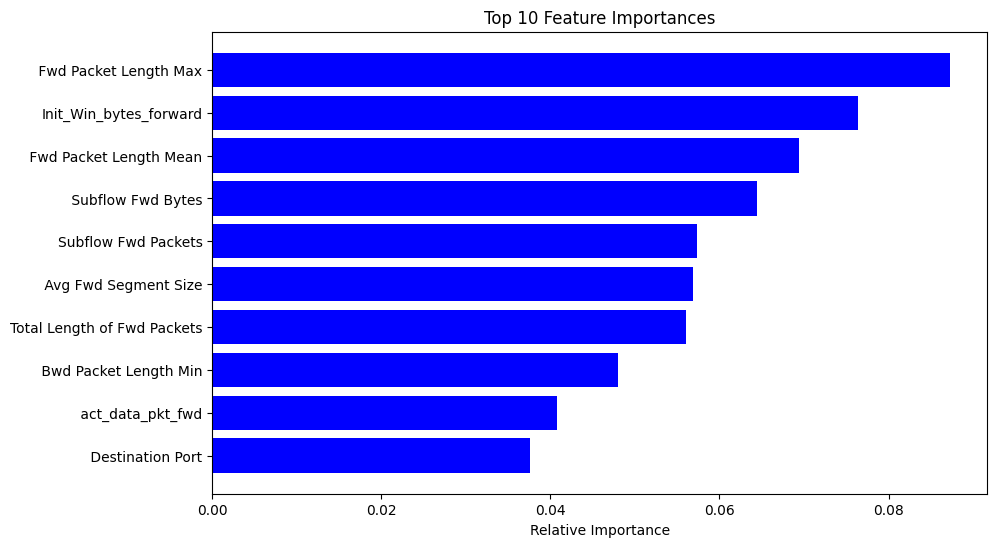

In [23]:
import matplotlib.pyplot as plt
import numpy as np

importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 important features
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
